# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
from os import makedirs
from os.path import isfile, isdir, join, exists

data_dir   = './data'
prefix     = '.'
pkl_folder = 'pkl-files'
pkl_prefix = join(prefix, pkl_folder)

pkl_sub    = 'saved_var_checkpoint'                  #sub-folder
pkl_subpth = join(pkl_prefix, pkl_sub)       #filename will be added at runtime 

chk_folder = 'checkpoints'
chk_prefix = join(prefix, chk_folder)

chk_sub    = 'historic_losses'                       #sub-folder
chk_subpth  = join(chk_prefix, chk_sub)       #filename will be added at runtime

f_names = [chk_subpth, pkl_subpth, data_dir]

for foldername in f_names:
    if not exists(foldername):
        makedirs(foldername)

if not isdir(pkl_subpth):
    raise Exception("pkl directory doesn't exist!")
if not isdir(chk_subpth):
    raise Exception("Checkpoints directory doesn't exist!")

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

       
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim      = (image_width, image_height, image_channels)
    inputs_real   = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim),     name='input_z')
    learning_rate = tf.placeholder(tf.float32, None,              name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(r, alpha=0.2):
    return tf.maximum(alpha * r, r)

def array_product(array):
    result = 1
    for n in array:
        result *= int(n)
    return result

In [7]:
Dkeep_prob      = 0.4            # initialize

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Using dropout in discrimnator, as a means to keep D-loss over G-loss,  
    # to allow the GAN -as a whole- to learn more effectively.
    
    global Dkeep_prob            
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    # no batch norm on the 1st layer
    with tf.variable_scope('discriminator', reuse=reuse):
        kernel_size = 4
        conv1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop1 = tf.layers.dropout(conv1, Dkeep_prob)
        leak1 = leaky_relu(drop1, alpha=alpha)
        #print("leak1.sh",leak1.shape) #leak1.sh (?, 14, 14, 128)
        
        conv2 = tf.layers.conv2d(leak1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop2 = tf.layers.dropout(conv2, Dkeep_prob)
        bnor2 = tf.layers.batch_normalization(drop2, training=True)
        leak2 = leaky_relu(bnor2, alpha=alpha)
        #print("leak2.sh",leak2.shape) # leak2.sh (?, 7, 7, 256)
        
        conv3 = tf.layers.conv2d(leak2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop3 = tf.layers.dropout(conv3, Dkeep_prob)
        bnor3 = tf.layers.batch_normalization(drop3, training=True)
        leak3 = leaky_relu(bnor3, alpha=alpha)
        #print("leak3.sh",leak3.shape) # leak3.sh (?, 4, 4, 512)
    
        shape4 = tf.reshape(leak3, [-1, array_product(leak3.get_shape()[1:])])
        #print("shape4.sh",shape4.shape) # shape4.sh (?, 8192)
        
        logits = tf.layers.dense(shape4, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
Gkeep_prob      = 0.5            # initialize

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # I've expanded this gradually, but significantly in order to strengthen G
    # to give G "more room" for learning (and for dropout - to stabilize G)
    # the goal being though, to keep the G-loss lower than D-loss
    
    # print("z", z.shape)                    # z (?, 100)
    # target (28,28, out_channel_dim)

    # Gkeep_prob -another tool we use to make the G more steady, less irratic, less dependent on D
    global Gkeep_prob
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train): 
        kernel_size = 4
        strde       = 2
        dense = tf.layers.dense(z, 4*4*512)
        # print("dense", dense.shape)         # dense (?, 8192)
        
        shape1 = tf.reshape(dense, [-1, 4, 4, 512])
            
        bnor1  = tf.layers.batch_normalization(shape1, training=is_train)
        leak1  = leaky_relu(bnor1)
        # print("leak1", leak1.shape)        # leak1 (?, 4, 4, 512)

        if is_train:
            drop1  = tf.layers.dropout(leak1, Gkeep_prob)
        else:
            drop1  = tf.layers.dropout(leak1, 1)
        
        tran2  = tf.layers.conv2d_transpose(drop1, 256, kernel_size, strides=strde, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran2",tran2.shape)        # tran2 (?, 8, 8, 256)
        bili2  = tf.image.resize_images(tran2, [7, 7])    # default method=ResizeMethod.BILINEAR
        # print("bili2", bili2.shape)       # bili2 (?, 7, 7, 256)
        
        bnor3  = tf.layers.batch_normalization(bili2, training=is_train)
        leak3  = leaky_relu(bnor3)
        # print("leak3", leak3.shape)       # leak3 (?, 7, 7, 256)
        
        if is_train:
            drop3  = tf.layers.dropout(leak3, Gkeep_prob)
        else:
            drop3  = tf.layers.dropout(leak3, 1)
                
        tran3  = tf.layers.conv2d_transpose(drop3, 128, kernel_size, strides=strde, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran3",tran3.shape)        # tran3 (?, 14, 14, 128)
        
        bnor4  = tf.layers.batch_normalization(tran3, training=is_train)
        leak4  = leaky_relu(bnor4)
        
        if is_train:
            drop4  = tf.layers.dropout(leak4, Gkeep_prob)
        else:
            drop4  = tf.layers.dropout(leak4, 1)
                                
        logits = tf.layers.conv2d_transpose(drop4, out_channel_dim, kernel_size, strides=strde, padding='same')
        # print("logits",logits.shape)    # logits (?, 28, 28, 5)
        
        # print("chan",out_channel_dim)   # chan 5
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import pickle as pkl

import time
import datetime
from datetime import timedelta 

def timestmp():
    print ("tmstmp")
    print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
def split(start_time):
    split_time = time.time()
    time_dif   = split_time - start_time
    time_str = str(timedelta(seconds = int(time_dif)))
    return time_dif, time_str
    

In [13]:
import pylab 
import numpy as np

def plot_loss(losses, steps_graph):
    fig, ax = pyplot.subplots()
    step_list = [x* steps_graph for x in range(len(losses))]
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    

In [20]:
from collections import deque
import numpy as np

def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs pr. run
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # global
    global filename
    global Load_chk
    global steps_printline
    global steps_images
    global chkfilepth
    global pckfilepth
    global num_mv_avg    
    
    # var
    steps           = 0
    laststeps       = 0
    last_elapsed    = 0
    samples, losses = [], []
    start_time      = time.time()
    mov_av_list     = deque()
    
    image_dim = data_shape[1:]
    channels  = image_dim[-1]
    
    image_mode = "L" if channels == 1 else "RGB"
    
    input_real, input_z, lr = model_inputs(*image_dim, z_dim)
    d_loss, g_loss              = model_loss(input_real, input_z, channels)
    d_opt, g_opt                = model_opt(d_loss, g_loss, learning_rate, beta1)

    g_div_d = 2.1   # init        # if ((train_loss_g / train_loss_d)>=2.0):

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver           = tf.train.Saver()
        
        chk_suffix = '.chk'
        chkfilepth = os.path.join(chk_subpth, filename+chk_suffix)
        pkl_suffix = '.pkl'
        pklfilepth = os.path.join(pkl_subpth, filename+pkl_suffix)
        
        # we need to add .meta - to see that the 3 chkpoint files are present
        metapklfilepth = pklfilepth+'.meta'
        
        if (Load_chk==True):
            saver.restore(sess, chkfilepth)
            print('Model restored.')
            with open(pklfilepth, 'rb') as rl:
                losses = pkl.load(rl)
            print ('historic losses loaded')    
                
        timestmp    
        for epoch_i in range(epochs):
            line=0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0 #rescale the intensity range from (-.5,.5) to (-1,1)
                
                # Sample noise
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})

                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                # when G-loss is more than twice the D - run a 3rd opt
                if (g_div_d>=2.0):
                    _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                                
                if steps % steps_printline == 0:
                    line+=1
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    d_ste_g = (train_loss_d <= train_loss_g)
                    # when deviding d-loss cannot be 0
                    if (train_loss_d==0.0):
                        g_div_d = 3
                    else:
                        g_div_d = train_loss_g / train_loss_d
                    
                    elapsed_time, time_str = split(start_time)
                    elapsed_steps  = steps-laststeps
                    step_time      = elapsed_time-last_elapsed

                    if (len(mov_av_list)>num_mv_avg):
                        mov_av_list.popleft()
                        mov_av_list.append(step_time)
                    else:
                        mov_av_list.append(step_time)
                    mov_av = (np.mean(mov_av_list)/60)
                    
                    st_time_str    = str(timedelta(seconds = int(step_time)))
                    time_rest      = (((num_mv_avg*(epochs-(epoch_i+1)))+(num_mv_avg-line))*mov_av) 
                    #
                    print("Epoch:{:2}/{:2}".format(epoch_i+1, epochs),
                          "Time: {:8}s.".format(time_str),
                          "st_Tm: {:8}s.".format(st_time_str),
                          "mean:{:2.0f}m.".format(mov_av),
                          "#Steps:{:4},".format(steps),
                          "DLoss:{:7.4f}".format(train_loss_d),
                          "GLoss:{:7.4f}".format(train_loss_g),
                          "guess:{:4.0f}m.".format(time_rest))
                    #
                    laststeps = steps
                    last_elapsed = elapsed_time 
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if (steps == 1) or (steps % steps_images == 0): 
                    show_generator_output(sess, 25, input_z, channels, image_mode)
                    #
                    saver.save(sess, chkfilepth)
                    timestmp
                    print("checkpoint saved")
                    #
                    print("losses saved to: ",pklfilepth)    
                    with open(pklfilepth, 'wb') as wl:
                        pkl.dump(losses, wl)
                    #
                    if (steps == 1) and (Load_chk==True):
                        plot_loss(losses, steps_graph)
                    #
                if (steps % steps_graph == 0):
                    plot_loss(losses, steps_graph)
            #
        saver.save(sess, chkfilepth)
        timestmp
        print("checkpoint saved")
        #
        plot_loss(losses, steps_graph)
        show_generator_output(sess, 121, input_z, channels, image_mode)
        show_generator_output(sess, 64, input_z, channels, image_mode)
        show_generator_output(sess, 25, input_z, channels, image_mode)
        show_generator_output(sess, 4, input_z, channels, image_mode)
        
    print("pickle should open: ",pklfilepth)    
    with open(pklfilepth, 'wb') as wl:
        pkl.dump(losses, wl)
    print ("finished training {} epochs".format(epochs))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

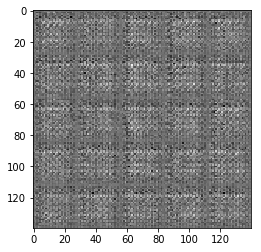

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 1/ 2 Time: 0:00:38 s. st_Tm: 0:00:38 s. mean: 1m. #Steps:  64, DLoss: 2.1414 GLoss: 0.2877 guess:  37m.
Epoch: 1/ 2 Time: 0:01:10 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 128, DLoss: 1.1702 GLoss: 0.8271 guess:  33m.
Epoch: 1/ 2 Time: 0:01:41 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 192, DLoss: 1.3153 GLoss: 0.7122 guess:  31m.
Epoch: 1/ 2 Time: 0:02:12 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 256, DLoss: 1.2722 GLoss: 0.6159 guess:  30m.
Epoch: 1/ 2 Time: 0:02:44 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 320, DLoss: 1.1441 GLoss: 0.9368 guess:  29m.
Epoch: 1/ 2 Time: 0:03:14 s. st_Tm: 0:00:30 s. mean: 1m. #Steps: 384, DLoss: 1.3507 GLoss: 0.6395 guess:  28m.
Epoch: 1/ 2 Time: 0:03:46 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 448, DLoss: 1.2884 GLoss: 0.5072 guess:  27m.
Epoch: 1/ 2 Time: 0:04:17 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 512, DLoss: 1.5689 GLoss: 0.5807 guess:  27m.
Epoch: 1/ 2 Time: 0:04:48 s. s

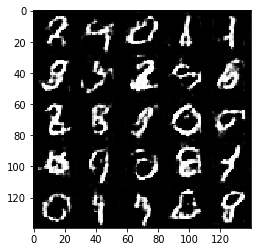

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 1/ 2 Time: 0:05:52 s. st_Tm: 0:00:32 s. mean: 1m. #Steps: 704, DLoss: 1.0309 GLoss: 0.7523 guess:  25m.
Epoch: 1/ 2 Time: 0:06:23 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 768, DLoss: 0.9959 GLoss: 0.7834 guess:  24m.
Epoch: 1/ 2 Time: 0:06:54 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 832, DLoss: 1.0974 GLoss: 0.6748 guess:  24m.
Epoch: 1/ 2 Time: 0:07:25 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 896, DLoss: 2.6723 GLoss: 0.0985 guess:  23m.
Epoch: 1/ 2 Time: 0:07:57 s. st_Tm: 0:00:31 s. mean: 1m. #Steps: 960, DLoss: 1.3814 GLoss: 0.3995 guess:  23m.
Epoch: 1/ 2 Time: 0:08:27 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1024, DLoss: 1.0138 GLoss: 0.7241 guess:  22m.
Epoch: 1/ 2 Time: 0:08:59 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:1088, DLoss: 1.4764 GLoss: 0.3163 guess:  22m.
Epoch: 1/ 2 Time: 0:09:30 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:1152, DLoss: 2.0933 GLoss: 0.1749 guess:  21m.
Epoch: 1/ 2 Time: 0:10:01 s. s

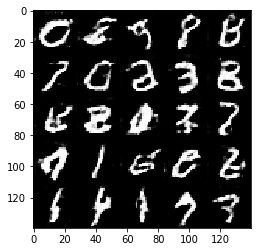

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


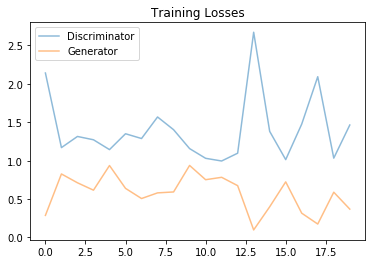

Epoch: 1/ 2 Time: 0:11:05 s. st_Tm: 0:00:33 s. mean: 1m. #Steps:1344, DLoss: 1.3981 GLoss: 0.3722 guess:  20m.
Epoch: 1/ 2 Time: 0:11:36 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1408, DLoss: 1.0731 GLoss: 0.8303 guess:  19m.
Epoch: 1/ 2 Time: 0:12:07 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1472, DLoss: 0.9735 GLoss: 0.6268 guess:  18m.
Epoch: 1/ 2 Time: 0:12:38 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:1536, DLoss: 1.1683 GLoss: 0.5617 guess:  18m.
Epoch: 1/ 2 Time: 0:13:09 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1600, DLoss: 1.6479 GLoss: 0.3765 guess:  17m.
Epoch: 1/ 2 Time: 0:13:40 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1664, DLoss: 0.8758 GLoss: 0.9057 guess:  17m.
Epoch: 1/ 2 Time: 0:14:10 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1728, DLoss: 1.6117 GLoss: 0.2957 guess:  16m.
Epoch: 1/ 2 Time: 0:14:41 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1792, DLoss: 0.7648 GLoss: 0.7577 guess:  16m.
Epoch: 1/ 2 Time: 0:15:12 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:1856, DLoss: 0.8127 GLoss: 0.9397 guess:  15m.
E

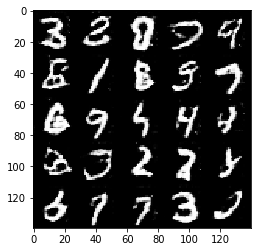

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 2/ 2 Time: 0:16:15 s. st_Tm: 0:00:32 s. mean: 1m. #Steps:1984, DLoss: 1.2902 GLoss: 0.4546 guess:  14m.
Epoch: 2/ 2 Time: 0:16:46 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:2048, DLoss: 2.1041 GLoss: 0.1731 guess:  14m.
Epoch: 2/ 2 Time: 0:17:17 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:2112, DLoss: 1.1738 GLoss: 0.5246 guess:  13m.
Epoch: 2/ 2 Time: 0:17:48 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:2176, DLoss: 1.2657 GLoss: 0.4730 guess:  12m.
Epoch: 2/ 2 Time: 0:18:19 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:2240, DLoss: 1.0295 GLoss: 0.6937 guess:  12m.
Epoch: 2/ 2 Time: 0:18:50 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:2304, DLoss: 0.7242 GLoss: 1.0748 guess:  11m.
Epoch: 2/ 2 Time: 0:19:21 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:2368, DLoss: 1.1282 GLoss: 1.9263 guess:  11m.
Epoch: 2/ 2 Time: 0:19:52 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:2432, DLoss: 1.1019 GLoss: 0.5827 guess:  10m.
Epoch: 2/ 2 Time: 0:20:23 s. s

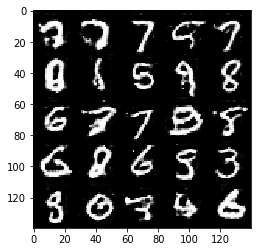

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


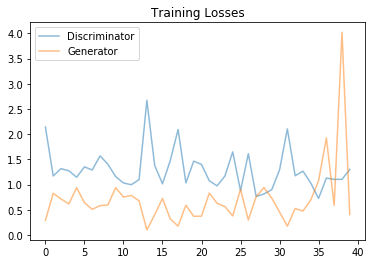

Epoch: 2/ 2 Time: 0:21:29 s. st_Tm: 0:00:32 s. mean: 1m. #Steps:2624, DLoss: 0.8848 GLoss: 2.9009 guess:   9m.
Epoch: 2/ 2 Time: 0:22:03 s. st_Tm: 0:00:33 s. mean: 1m. #Steps:2688, DLoss: 2.1969 GLoss: 0.1944 guess:   8m.
Epoch: 2/ 2 Time: 0:22:33 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:2752, DLoss: 1.3204 GLoss: 0.4218 guess:   8m.
Epoch: 2/ 2 Time: 0:23:05 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:2816, DLoss: 1.1315 GLoss: 0.4885 guess:   7m.
Epoch: 2/ 2 Time: 0:23:35 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:2880, DLoss: 0.7269 GLoss: 0.9937 guess:   7m.
Epoch: 2/ 2 Time: 0:24:06 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:2944, DLoss: 1.5468 GLoss: 0.3532 guess:   6m.
Epoch: 2/ 2 Time: 0:24:38 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:3008, DLoss: 0.6611 GLoss: 1.2956 guess:   6m.
Epoch: 2/ 2 Time: 0:25:09 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:3072, DLoss: 1.0973 GLoss: 0.7289 guess:   5m.
Epoch: 2/ 2 Time: 0:25:40 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:3136, DLoss: 2.0716 GLoss: 0.2037 guess:   5m.
E

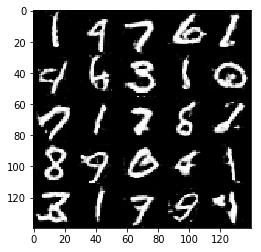

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 2/ 2 Time: 0:26:47 s. st_Tm: 0:00:35 s. mean: 1m. #Steps:3264, DLoss: 1.5360 GLoss: 0.3109 guess:   4m.
Epoch: 2/ 2 Time: 0:27:18 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:3328, DLoss: 1.4278 GLoss: 0.3636 guess:   3m.
Epoch: 2/ 2 Time: 0:27:48 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:3392, DLoss: 0.7713 GLoss: 0.8722 guess:   3m.
Epoch: 2/ 2 Time: 0:28:21 s. st_Tm: 0:00:32 s. mean: 1m. #Steps:3456, DLoss: 1.6683 GLoss: 0.2711 guess:   2m.
Epoch: 2/ 2 Time: 0:28:52 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:3520, DLoss: 0.9366 GLoss: 0.7421 guess:   2m.
Epoch: 2/ 2 Time: 0:29:23 s. st_Tm: 0:00:30 s. mean: 1m. #Steps:3584, DLoss: 1.5987 GLoss: 0.3087 guess:   1m.
Epoch: 2/ 2 Time: 0:29:54 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:3648, DLoss: 0.9238 GLoss: 0.7702 guess:   1m.
Epoch: 2/ 2 Time: 0:30:25 s. st_Tm: 0:00:31 s. mean: 1m. #Steps:3712, DLoss: 0.6372 GLoss: 0.9497 guess:   0m.
checkpoint saved


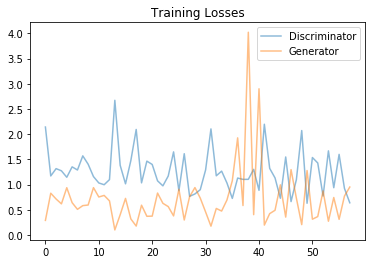

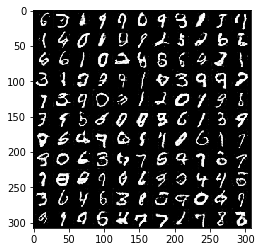

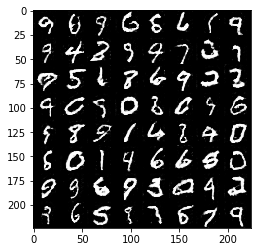

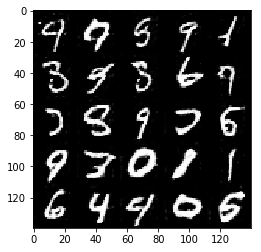

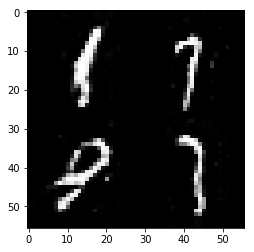

pickle should open:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
finished training 2 epochs


In [21]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""
# std. Hyper param
batch_size      = 32
z_dim           = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a much higher lr
# I can't say anything other than: these hyperparam worked for me - hope they will for you too.
learning_rate   = 0.0002
beta1           = 0.6

# to seperate the two data-runs, I will have to give the files different names 
filename        = 'MNIST_run'

#set this to [ True ], if you want to load the checkpoint and loss-file
Load_chk        =  False         #True

Gkeep_prob      = 0.3          
Dkeep_prob      = 0.3          

num_mv_avg      =   29 
steps_printline =   64 

steps_images    =  640 
steps_graph     = 1280


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

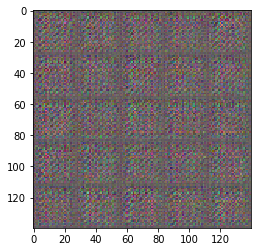

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 1 Time: 0:01:18 s. st_Tm: 0:01:18 s. mean: 1m. #Steps: 128, DLoss: 1.8379 GLoss: 0.5275 guess:  63m.
Epoch: 1/ 1 Time: 0:02:25 s. st_Tm: 0:01:06 s. mean: 1m. #Steps: 256, DLoss: 1.5844 GLoss: 0.6919 guess:  57m.
Epoch: 1/ 1 Time: 0:03:32 s. st_Tm: 0:01:06 s. mean: 1m. #Steps: 384, DLoss: 1.7253 GLoss: 0.6479 guess:  54m.
Epoch: 1/ 1 Time: 0:04:38 s. st_Tm: 0:01:06 s. mean: 1m. #Steps: 512, DLoss: 1.5892 GLoss: 0.6005 guess:  52m.
Epoch: 1/ 1 Time: 0:05:44 s. st_Tm: 0:01:06 s. mean: 1m. #Steps: 640, DLoss: 1.6387 GLoss: 0.5938 guess:  51m.
Epoch: 1/ 1 Time: 0:06:51 s. st_Tm: 0:01:06 s. mean: 1m. #Steps: 768, DLoss: 1.6191 GLoss: 0.6085 guess:  49m.
Epoch: 1/ 1 Time: 0:07:57 s. st_Tm: 0:01:06 s. mean: 1m. #Steps: 896, DLoss: 1.5935 GLoss: 0.5802 guess:  48m.
Epoch: 1/ 1 Time: 0:09:04 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:1024, DLoss: 1.4445 GLoss: 0.7086 guess:  46m.
Epoch: 1/ 1 Time: 0:10:11 s. 

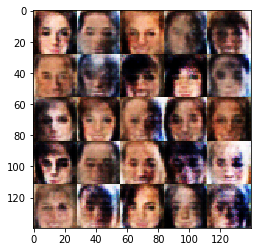

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 1 Time: 0:12:26 s. st_Tm: 0:01:08 s. mean: 1m. #Steps:1408, DLoss: 1.4386 GLoss: 0.7574 guess:  43m.
Epoch: 1/ 1 Time: 0:13:34 s. st_Tm: 0:01:07 s. mean: 1m. #Steps:1536, DLoss: 1.5320 GLoss: 0.6005 guess:  42m.
Epoch: 1/ 1 Time: 0:14:40 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:1664, DLoss: 1.4945 GLoss: 0.5718 guess:  41m.
Epoch: 1/ 1 Time: 0:15:47 s. st_Tm: 0:01:07 s. mean: 1m. #Steps:1792, DLoss: 1.4101 GLoss: 0.6320 guess:  39m.
Epoch: 1/ 1 Time: 0:16:54 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:1920, DLoss: 1.4933 GLoss: 0.6127 guess:  38m.
Epoch: 1/ 1 Time: 0:18:01 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:2048, DLoss: 1.4838 GLoss: 0.7209 guess:  37m.
Epoch: 1/ 1 Time: 0:19:07 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:2176, DLoss: 1.3894 GLoss: 0.6433 guess:  36m.
Epoch: 1/ 1 Time: 0:20:14 s. st_Tm: 0:01:07 s. mean: 1m. #Steps:2304, DLoss: 1.3769 GLoss: 0.6490 guess:  35m.
Epoch: 1/ 1 Time: 0:21:21 s. 

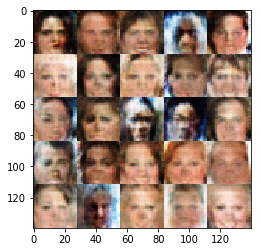

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


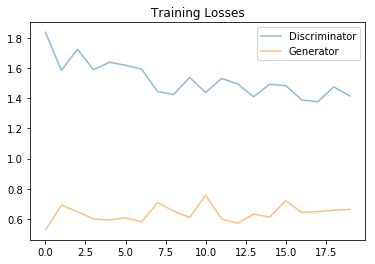

Epoch: 1/ 1 Time: 0:23:36 s. st_Tm: 0:01:08 s. mean: 1m. #Steps:2688, DLoss: 1.4311 GLoss: 0.6445 guess:  31m.
Epoch: 1/ 1 Time: 0:24:43 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:2816, DLoss: 1.4991 GLoss: 0.6608 guess:  30m.
Epoch: 1/ 1 Time: 0:25:50 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:2944, DLoss: 1.4338 GLoss: 0.7001 guess:  29m.
Epoch: 1/ 1 Time: 0:26:59 s. st_Tm: 0:01:09 s. mean: 1m. #Steps:3072, DLoss: 1.4603 GLoss: 0.6439 guess:  28m.
Epoch: 1/ 1 Time: 0:28:08 s. st_Tm: 0:01:09 s. mean: 1m. #Steps:3200, DLoss: 1.4054 GLoss: 0.7070 guess:  27m.
Epoch: 1/ 1 Time: 0:29:16 s. st_Tm: 0:01:07 s. mean: 1m. #Steps:3328, DLoss: 1.3810 GLoss: 0.7045 guess:  26m.
Epoch: 1/ 1 Time: 0:30:22 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:3456, DLoss: 1.4507 GLoss: 0.6335 guess:  25m.
Epoch: 1/ 1 Time: 0:31:29 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:3584, DLoss: 1.4503 GLoss: 0.6173 guess:  24m.
Epoch: 1/ 1 Time: 0:32:36 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:3712, DLoss: 1.3910 GLoss: 0.7319 guess:  22m.
E

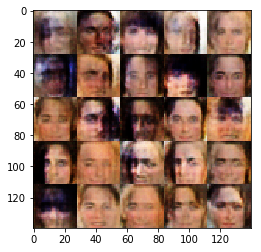

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 1 Time: 0:34:53 s. st_Tm: 0:01:09 s. mean: 1m. #Steps:3968, DLoss: 1.4909 GLoss: 0.7167 guess:  20m.
Epoch: 1/ 1 Time: 0:36:00 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:4096, DLoss: 1.4286 GLoss: 0.7345 guess:  19m.
Epoch: 1/ 1 Time: 0:37:07 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:4224, DLoss: 1.4336 GLoss: 0.6757 guess:  18m.
Epoch: 1/ 1 Time: 0:38:13 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:4352, DLoss: 1.3888 GLoss: 0.6877 guess:  17m.
Epoch: 1/ 1 Time: 0:39:20 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:4480, DLoss: 1.4816 GLoss: 0.6543 guess:  16m.
Epoch: 1/ 1 Time: 0:40:26 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:4608, DLoss: 1.5509 GLoss: 0.5944 guess:  15m.
Epoch: 1/ 1 Time: 0:41:33 s. st_Tm: 0:01:06 s. mean: 1m. #Steps:4736, DLoss: 1.5583 GLoss: 0.6139 guess:  13m.
Epoch: 1/ 1 Time: 0:42:40 s. st_Tm: 0:01:07 s. mean: 1m. #Steps:4864, DLoss: 1.4479 GLoss: 0.6034 guess:  12m.
Epoch: 1/ 1 Time: 0:43:47 s. 

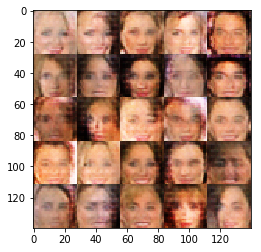

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


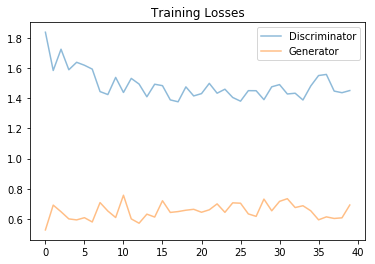

Epoch: 1/ 1 Time: 0:46:03 s. st_Tm: 0:01:08 s. mean: 1m. #Steps:5248, DLoss: 1.3023 GLoss: 0.6964 guess:   9m.
Epoch: 1/ 1 Time: 0:47:17 s. st_Tm: 0:01:14 s. mean: 1m. #Steps:5376, DLoss: 1.3926 GLoss: 0.6526 guess:   8m.
Epoch: 1/ 1 Time: 0:48:29 s. st_Tm: 0:01:12 s. mean: 1m. #Steps:5504, DLoss: 1.3478 GLoss: 0.6970 guess:   7m.
Epoch: 1/ 1 Time: 0:49:37 s. st_Tm: 0:01:08 s. mean: 1m. #Steps:5632, DLoss: 1.4029 GLoss: 0.7542 guess:   6m.
Epoch: 1/ 1 Time: 0:50:46 s. st_Tm: 0:01:08 s. mean: 1m. #Steps:5760, DLoss: 1.4855 GLoss: 0.5960 guess:   5m.
Epoch: 1/ 1 Time: 0:51:55 s. st_Tm: 0:01:08 s. mean: 1m. #Steps:5888, DLoss: 1.3192 GLoss: 0.6623 guess:   3m.
Epoch: 1/ 1 Time: 0:53:04 s. st_Tm: 0:01:09 s. mean: 1m. #Steps:6016, DLoss: 1.4666 GLoss: 0.5819 guess:   2m.
Epoch: 1/ 1 Time: 0:54:14 s. st_Tm: 0:01:09 s. mean: 1m. #Steps:6144, DLoss: 1.4678 GLoss: 0.6022 guess:   1m.
Epoch: 1/ 1 Time: 0:55:21 s. st_Tm: 0:01:07 s. mean: 1m. #Steps:6272, DLoss: 1.3869 GLoss: 0.6651 guess:   0m.
c

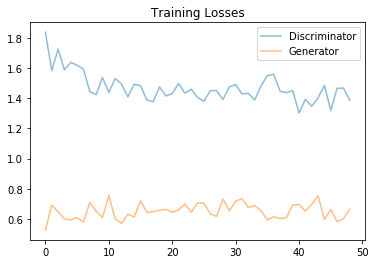

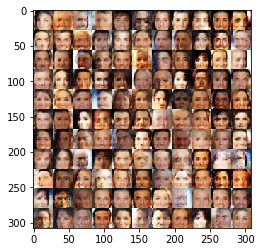

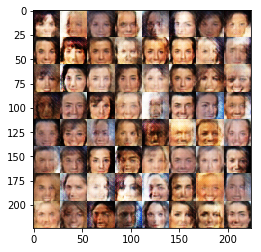

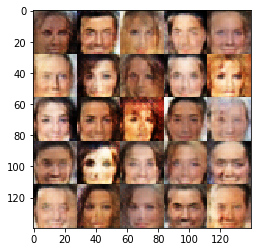

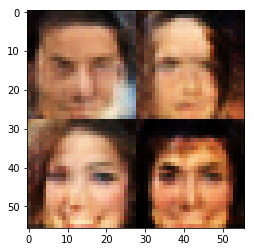

pickle should open:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
finished training 1 epochs


In [23]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""

# std. Hyper param
batch_size      = 32
z_dim           = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these worked for me - hope they will for you too.
learning_rate   = 0.0002
beta1           = 0.6

# to seperate the two data-runs, I will have to give the files different names 
filename        = 'CelebA_run'

#set this to [ True ], if you want to load the checkpoint and loss-file
Load_chk        =  False         #True

Gkeep_prob      = 0.3  
Dkeep_prob      = 0.4

num_mv_avg      =  49                            
steps_printline = 128

steps_images    = 1280 
steps_graph     = 2560


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.